In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Q 1 Load the dataset

In [3]:
transform = transforms . Compose ([ transforms . ToTensor () ,
transforms . Normalize ((0.5 , ) ,
(0.5 ,) ) ])
trainset = datasets . FashionMNIST ( ' ~/. pytorch / F_MNIST_data / ' ,
download = True , train = True , transform = transform )
trainloader = torch . utils . data . DataLoader ( trainset , batch_size
=32 , shuffle = True )
testset = datasets . FashionMNIST ( ' ~/. pytorch / F_MNIST_data / ' ,
download = True , train = False , transform = transform )
testloader = torch . utils . data . DataLoader ( testset , batch_size =32 ,
shuffle = False )

In [4]:
batch = next ( iter ( trainloader ) )
print ( batch [0]. shape , batch [1]. shape )

torch.Size([32, 1, 28, 28]) torch.Size([32])


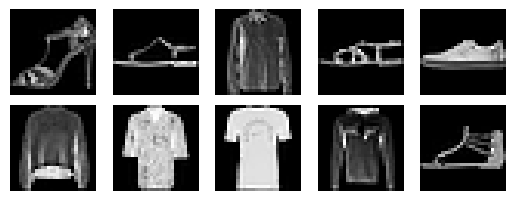

In [5]:
import matplotlib . pyplot as plt
f , ax = plt . subplots (2 , 5)
plt . subplots_adjust ( bottom =0.3 , top =0.7 , hspace =0)
for i in range (2) :
    for j in range (5) :
        image , label = next ( iter ( trainloader ) )
        ax [ i ][ j ]. set_axis_off ()
        ax [ i ][ j ]. imshow ( image [0 ,0 ,:] , cmap = 'gray')

# Q 2 Multilayer Perceptrons

# Flattening is done in the def train_model using images.view(images.size(0), -1)

In [6]:
# Define the model building function
def build_model(input_size, hidden_layers, output_size, activation_fn):
    layers = [nn.Linear(input_size, hidden_layers[0]), activation_fn()]
    for i in range(1, len(hidden_layers)):
        layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        layers.append(activation_fn())
        layers.append(nn.Dropout(0.2))
    layers.append(nn.Linear(hidden_layers[-1], output_size))
    return nn.Sequential(*layers)

def train_model(model, trainloader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total = 0
        correct = 0
        for images, labels in trainloader:
            images = images.view(images.size(0), -1) # This flattens the image
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    training_accuracy = correct / total
    return training_accuracy

# Evaluation function
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Experimenting with 5 different structures and run on 100 epoch on a size of 784; output class of 10. Using structures, these 5 structures; [[32], [64], [128], [32, 16], [64, 32, 16]]; the best structure we will see we got is 128

In [10]:
# Experiment configurations
network_structures = [[32], [64], [128], [32, 16], [64, 32, 16]]
input_size = 28*28  # 784 input features
output_size = 10    # 10 classes
num_epochs = 100     # Reduced for quicker experimentation

results = []

# Experiment with different network structures
for structure in network_structures:
    model = build_model(input_size, structure, output_size, nn.ReLU)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    training_accuracy = train_model(model, trainloader, criterion, optimizer, num_epochs)
    test_accuracy = evaluate_model(model, testloader)
    results.append({
        'structure': structure, 
        'activation_function': 'ReLU', 
        'training_accuracy': training_accuracy, 
        'test_accuracy': test_accuracy
    })

# Find the best performing structure
best_structure = max(results, key=lambda x: x['test_accuracy'])['structure']
print(best_structure)

activation_functions = [nn.Sigmoid, nn.ELU, nn.LeakyReLU]

# Experiment with different activation functions on the best performing structure
for activation_fn in activation_functions:
    model = build_model(input_size, best_structure, output_size, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    training_accuracy = train_model(model, trainloader, criterion, optimizer, num_epochs)
    test_accuracy = evaluate_model(model, testloader)
    results.append({
        'structure': best_structure, 
        'activation_function': activation_fn.__name__, 
        'training_accuracy': training_accuracy, 
        'test_accuracy': test_accuracy
    })

# Print the results
for result in results:
    print(f"Structure: {result['structure']}, "
          f"Activation Function: {result['activation_function']}, "
          f"Training Accuracy: {result['training_accuracy']:.2f}%, "
          f"Testing Accuracy: {result['test_accuracy']:.2f}%")

# Summarize insights here

[128]
Structure: [32], Activation Function: ReLU, Training Accuracy: 0.93%, Testing Accuracy: 0.88%
Structure: [64], Activation Function: ReLU, Training Accuracy: 0.95%, Testing Accuracy: 0.88%
Structure: [128], Activation Function: ReLU, Training Accuracy: 0.97%, Testing Accuracy: 0.89%
Structure: [32, 16], Activation Function: ReLU, Training Accuracy: 0.90%, Testing Accuracy: 0.87%
Structure: [64, 32, 16], Activation Function: ReLU, Training Accuracy: 0.92%, Testing Accuracy: 0.88%
Structure: [128], Activation Function: Sigmoid, Training Accuracy: 0.91%, Testing Accuracy: 0.88%
Structure: [128], Activation Function: ELU, Training Accuracy: 0.95%, Testing Accuracy: 0.88%
Structure: [128], Activation Function: LeakyReLU, Training Accuracy: 0.96%, Testing Accuracy: 0.89%


# Implement the CNN 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Define the CNN architecture
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # (a)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # (b)
        self.flatten = nn.Flatten()  # (c)
        self.fc1 = nn.Linear(32 * 13 * 13, 100)  # (d)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)  # (e)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Convolutional layer and MaxPool
        x = self.flatten(x)  # FlattenI just 
        x = self.relu(self.fc1(x))  # Dense layer with ReLU
        x = self.fc2(x)  # Output layer
        return x

# Instantiate the model
model = BaselineCNN()
model.apply(init_weights)

# Set up optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD with specified parameters
loss = nn.CrossEntropyLoss()

# Print the shape of the output at each layer
X = torch.ones((1, 1, 28, 28))
for layer in model.children():
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
    
# Count of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", trainable_params)


Conv2d output shape:	 torch.Size([1, 32, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 32, 13, 13])
Flatten output shape:	 torch.Size([1, 5408])
Linear output shape:	 torch.Size([1, 100])
ReLU output shape:	 torch.Size([1, 100])
Linear output shape:	 torch.Size([1, 10])
Number of trainable parameters: 542230


In [14]:
# Instantiate the model
model = BaselineCNN()
model.apply(init_weights)

# Set up optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(10):  # 10 epochs
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%')

Epoch 1, Loss: 0.4167644999861717
Epoch 2, Loss: 0.2838522619813681
Epoch 3, Loss: 0.2469263154288133
Epoch 4, Loss: 0.21709833960731825
Epoch 5, Loss: 0.1929622971996665
Epoch 6, Loss: 0.17282053106240927
Epoch 7, Loss: 0.15487319336757063
Epoch 8, Loss: 0.13923468367904424
Epoch 9, Loss: 0.12532018612995743
Epoch 10, Loss: 0.10854268128623565
Accuracy on test data: 90.14%


# Base CNN training without any Dropout or BatchNorm

Epoch 10, Loss: 0.10939872224926948, Training Accuracy: 95.90%, Validation Accuracy: 90.56%
Epoch 20, Loss: 0.035630113689387996, Training Accuracy: 98.74%, Validation Accuracy: 90.71%
Epoch 30, Loss: 0.00465272673703245, Training Accuracy: 99.86%, Validation Accuracy: 91.23%
Epoch 40, Loss: 0.00019967551584956406, Training Accuracy: 100.00%, Validation Accuracy: 91.59%
Epoch 50, Loss: 0.00011995067876252581, Training Accuracy: 100.00%, Validation Accuracy: 91.62%


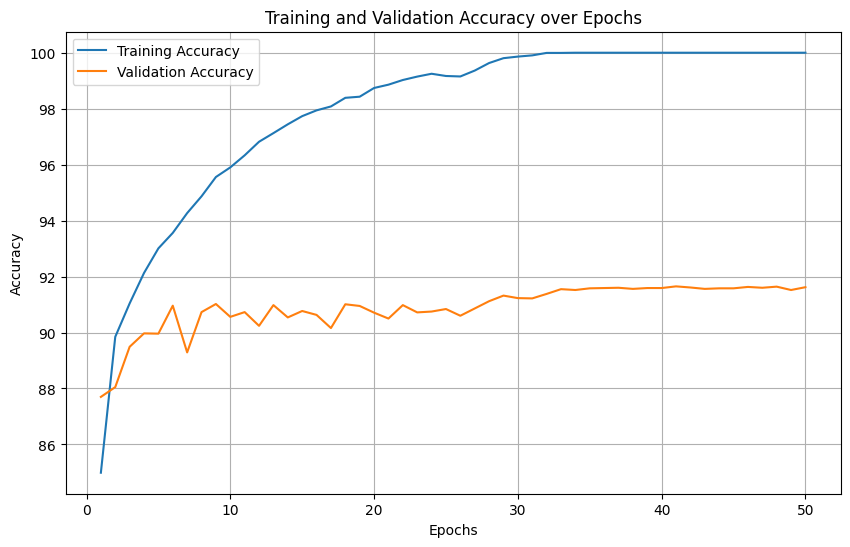

In [16]:
# Instantiate the model
model = BaselineCNN()
model.apply(init_weights)

# Set up optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Initialize lists to store accuracies
training_accuracies = []
validation_accuracies = []

# Training and Evaluation Loop
for epoch in range(50):  # 50 epochs
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    training_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total
    validation_accuracies.append(valid_accuracy)

    if (epoch + 1) % 10 == 0:  # Check if the epoch number is divisible by 10
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, "
              f"Training Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {valid_accuracy:.2f}%")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), training_accuracies, label='Training Accuracy')
plt.plot(range(1, 51), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Modified CNN by including Dropout

In [17]:
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # (a)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # (b)
        self.flatten = nn.Flatten()  # (c)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(32 * 13 * 13, 100)  # (d)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)  # (e)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 10, Loss: 0.00011995067876252581, Training Accuracy: 95.18%, Validation Accuracy: 90.97%
Epoch 20, Loss: 0.00011995067876252581, Training Accuracy: 97.65%, Validation Accuracy: 90.88%
Epoch 30, Loss: 0.00011995067876252581, Training Accuracy: 98.81%, Validation Accuracy: 91.12%
Epoch 40, Loss: 0.00011995067876252581, Training Accuracy: 99.21%, Validation Accuracy: 91.13%
Epoch 50, Loss: 0.00011995067876252581, Training Accuracy: 99.48%, Validation Accuracy: 91.06%


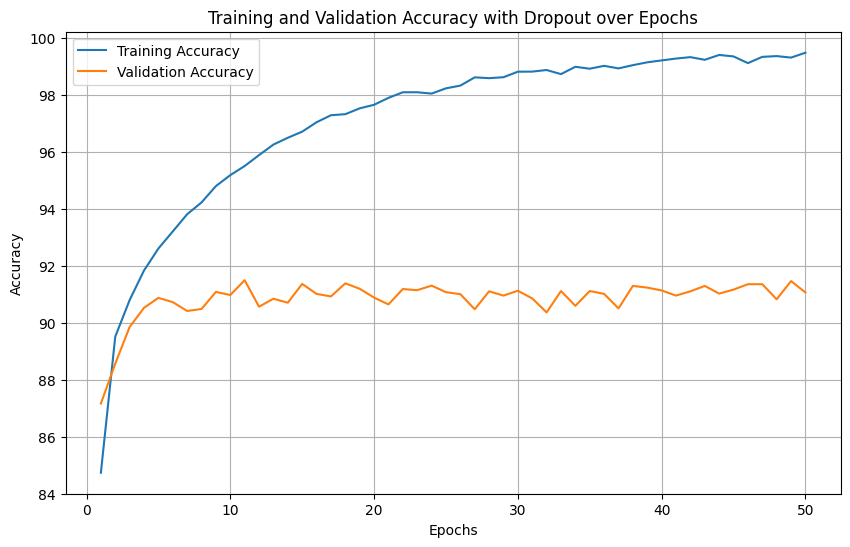

In [20]:
import matplotlib.pyplot as plt

def train_and_evaluate(model, trainloader, testloader, optimizer, criterion, num_epochs):
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        training_accuracies.append(train_accuracy)

        model.eval()
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_accuracy = 100 * valid_correct / valid_total
        validation_accuracies.append(valid_accuracy)

        if (epoch + 1) % 10 == 0:  # Check if the epoch number is divisible by 10
            print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, "
                f"Training Accuracy: {train_accuracy:.2f}%, "
                f"Validation Accuracy: {valid_accuracy:.2f}%")

    return training_accuracies, validation_accuracies

# Instantiate and train the modified model with dropout
model_with_dropout = ModifiedCNN()
model_with_dropout.apply(init_weights)

optimizer = optim.SGD(model_with_dropout.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_acc_dropout, test_acc_dropout = train_and_evaluate(model_with_dropout, trainloader, testloader, optimizer, criterion, num_epochs=50)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_acc_dropout, label='Training Accuracy')
plt.plot(range(1, 51), test_acc_dropout, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Dropout over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Enchanced CNN by adding additional Convolutional Layer and MaxPooling Layer including the dropout layer

In [21]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)  # Original Convolutional layer
        self.pool1 = nn.MaxPool2d(2, 2)   # Original Maxpooling layer
        self.conv2 = nn.Conv2d(32, 64, 3) # Additional Convolutional layer with 64 filters
        self.pool2 = nn.MaxPool2d(2, 2)   # Additional Maxpooling layer
        self.flatten = nn.Flatten()       # Flatten layer
        self.dropout = nn.Dropout(0.5)    # Dropout layer
        # Adjusted dense layer considering the output of the last maxpooling layer
        self.fc1 = nn.Linear(64 * 5 * 5, 100) # Adjusted Dense layer
        self.relu = nn.ReLU()                  # ReLU activation
        self.fc2 = nn.Linear(100, 10)          # Output layer

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(x)  # Apply dropout here
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 10, Loss: 0.00011995067876252581, Training Accuracy: 90.71%, Validation Accuracy: 90.64%
Epoch 20, Loss: 0.00011995067876252581, Training Accuracy: 92.32%, Validation Accuracy: 91.45%
Epoch 30, Loss: 0.00011995067876252581, Training Accuracy: 93.19%, Validation Accuracy: 91.73%
Epoch 40, Loss: 0.00011995067876252581, Training Accuracy: 93.90%, Validation Accuracy: 91.96%
Epoch 50, Loss: 0.00011995067876252581, Training Accuracy: 94.40%, Validation Accuracy: 91.41%


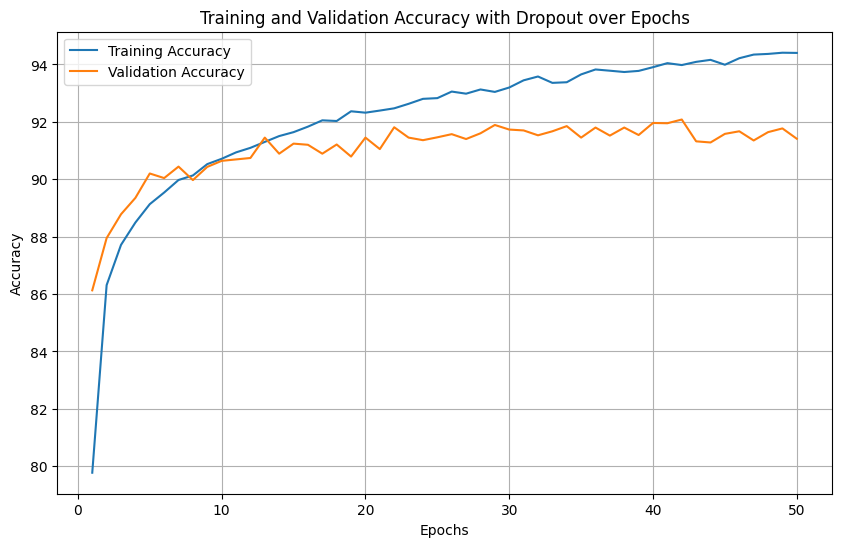

In [25]:
import matplotlib.pyplot as plt

def train_and_evaluate(model, trainloader, testloader, optimizer, criterion, num_epochs):
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        training_accuracies.append(train_accuracy)

        model.eval()
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_accuracy = 100 * valid_correct / valid_total
        validation_accuracies.append(valid_accuracy)

        if (epoch + 1) % 10 == 0:  # Check if the epoch number is divisible by 10
            print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, "
                f"Training Accuracy: {train_accuracy:.2f}%, "
                f"Validation Accuracy: {valid_accuracy:.2f}%")

    return training_accuracies, validation_accuracies

# Instantiate and train the modified model with dropout
model_with_dropout = EnhancedCNN()
model_with_dropout.apply(init_weights)

optimizer = optim.SGD(model_with_dropout.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_acc_dropout, test_acc_dropout = train_and_evaluate(model_with_dropout, trainloader, testloader, optimizer, criterion, num_epochs=50)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_acc_dropout, label='Training Accuracy')
plt.plot(range(1, 51), test_acc_dropout, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Dropout over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def train_and_evaluate(model, trainloader, testloader, optimizer, criterion, num_epochs):
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        training_accuracies.append(train_accuracy)

        model.eval()
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_accuracy = 100 * valid_correct / valid_total
        validation_accuracies.append(valid_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, "
            f"Training Accuracy: {train_accuracy:.2f}%, "
            f"Validation Accuracy: {valid_accuracy:.2f}%")

    return training_accuracies, validation_accuracies

# Instantiate and train the modified model with dropout
model_with_dropout = EnhancedCNN()
model_with_dropout.apply(init_weights)

optimizer = optim.SGD(model_with_dropout.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_acc_dropout, test_acc_dropout = train_and_evaluate(model_with_dropout, trainloader, testloader, optimizer, criterion, num_epochs=50)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_acc_dropout, label='Training Accuracy')
plt.plot(range(1, 51), test_acc_dropout, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Dropout over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Assuming the EnhancedCNN class and init_weights function are defined as per your previous message

# Instantiate the enhanced model
enhanced_model = EnhancedCNN()
enhanced_model.apply(init_weights)

# Set up the optimizer with SGD
optimizer = optim.SGD(enhanced_model.parameters(), lr=0.01, momentum=0.9)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate the model
train_acc_enhanced, test_acc_enhanced = train_and_evaluate(enhanced_model, trainloader, testloader, optimizer, criterion, num_epochs=10)

# Print the test accuracy
print(f"Enhanced CNN with Additional Layers and Dropout - Test Accuracy: {test_acc_enhanced[-1]:.2f}%")

Epoch 10, Loss: 0.00011995067876252581, Training Accuracy: 90.88%, Validation Accuracy: 90.88%
Enhanced CNN with Additional Layers and Dropout - Test Accuracy: 90.88%


In [23]:
class EnhancedCNN2(nn.Module):
    def __init__(self):
        super(EnhancedCNN2, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Max-Pooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Max-Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten Layer
        self.flatten = nn.Flatten()
        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        
        # Dense Layer
        self.fc1 = nn.Linear(64 * 7 * 7, 100)  # Adjust this size according to your input size
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)  # Number of classes

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Instantiate the enhanced model for learning rate 0.001
model_lr001 = EnhancedCNN2()
model_lr001.apply(init_weights)

# Set up the optimizer with a learning rate of 0.001
optimizer_lr001 = optim.SGD(model_lr001.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate the model
criterion = nn.CrossEntropyLoss()
train_acc_lr001, test_acc_lr001 = train_and_evaluate(model_lr001, trainloader, testloader, optimizer_lr001, criterion, num_epochs=10)

# Print the test accuracy
print(f"Learning Rate 0.001 - Test Accuracy: {test_acc_lr001[-1]:.2f}%")


Epoch 10, Loss: 0.00011995067876252581, Training Accuracy: 89.34%, Validation Accuracy: 89.43%
Learning Rate 0.001 - Test Accuracy: 89.43%


In [24]:
# Instantiate the enhanced model for learning rate 0.1
model_lr01 = EnhancedCNN2()
model_lr01.apply(init_weights)

# Set up the optimizer with a learning rate of 0.1
optimizer_lr01 = optim.SGD(model_lr01.parameters(), lr=0.1, momentum=0.9)

# Train and evaluate the model
criterion = nn.CrossEntropyLoss()
train_acc_lr01, test_acc_lr01 = train_and_evaluate(model_lr01, trainloader, testloader, optimizer_lr01, criterion, num_epochs=10)

# Print the test accuracy
print(f"Learning Rate 0.1 - Test Accuracy: {test_acc_lr01[-1]:.2f}%")

Epoch 10, Loss: 0.00011995067876252581, Training Accuracy: 9.98%, Validation Accuracy: 10.00%
Learning Rate 0.1 - Test Accuracy: 10.00%


# ANALYSIS

* (a) Explain how the trends in validation and train accuracy change after using the dropout layer
in the experiments.

    * Effectiveness of Dropout: The dropout layer helps in regularizing the network, leading to better generalization. This is evident from the more consistent performance on both training and validation sets.
Prevention of Overfitting: Without dropout, the model tends to overfit, indicated by the high training accuracy and the divergence from the validation accuracy. Dropout mitigates this by ensuring that the model does not rely too heavily on any specific set of neurons.